In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

ACTIONS = {
    "U": (0, 1),
    "D": (0, -1),
    "L": (-1, 0),
    "R": (1, 0),
}


class GridQLearning:
    def __init__(self, grid_size: tuple[int, int], start_state: tuple[int, int], terminal_state: tuple[int, int], 
                 alpha: float, gamma: float, epsilon: float, beta: float, episodes: int, max_steps_per_episode: int = 100):
        self.grid_size = grid_size
        self.actions = ACTIONS
        self.all_states = [(r, c) for r in range(grid_size[0]) for c in range(grid_size[1])]
        self.start_state = start_state
        self.terminal_state = terminal_state
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta = beta
        self.episodes = episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.Q = defaultdict(float)
        self.t = 0
        
        # Storage for progression
        self.episode_records = []
        self.steps_per_episode = []
    
    def in_bounds(self, state):
        """Check if state is within grid bounds."""
        r, c = state
        return 0 <= r < self.grid_size[0] and 0 <= c < self.grid_size[1]

    def step(self, state: tuple[int, int], action: str):
        """Environment transition: move in grid with boundary clipping; reward 1 at terminal, else 0."""
        if state == self.terminal_state:
            return state, 0.0, True
        
        dr, dc = self.actions[action]
        r, c = state
        nr, nc = r + dr, c + dc
        
        # clip to bounds
        if not self.in_bounds((nr, nc)):
            nr, nc = r, c
        
        s_next = (nr, nc)
        rwd = 1.0 if s_next == self.terminal_state else 0.0
        done = s_next == self.terminal_state
        return s_next, rwd, done

    def epsilon_greedy_action(self, state):
        """ε-greedy over available actions (all actions valid; out-of-bounds stay put)."""
        if state == self.terminal_state:
            return None
        
        eps = self.epsilon * np.exp(-self.beta * self.t)

        if np.random.rand() < eps:
            action = np.random.choice(list(self.actions.keys()))
        else:
            # exploit: argmax with random tie-break among best
            qvals = {a: self.Q[(state, a)] for a in self.actions}
            max_q = max(qvals.values())
            best = [a for a, q in qvals.items() if q == max_q]
            action = np.random.choice(best)
        self.t += 1
        return action

    def train(self):
        """Train the Q-learning agent."""
        for ep in range(1, self.episodes + 1):
            s = self.start_state
            steps = 0
            
            for t in range(self.max_steps_per_episode):
                a = self.epsilon_greedy_action(s)
                if a is None:
                    break
                
                s_next, rwd, done = self.step(s, a)
                
                # Q-update
                if s_next == self.terminal_state:
                    max_next = 0.0
                else:
                    max_next = max(self.Q[(s_next, a2)] for a2 in self.actions)
                
                target = rwd + self.gamma * max_next
                self.Q[(s, a)] = self.Q[(s, a)] + self.alpha * (target - self.Q[(s, a)]) # update Q-value
                
                s = s_next
                steps += 1
                
                if done:
                    break
            
            self.steps_per_episode.append(steps)

            # Record full Q-table snapshot after this episode
            rec = {"Episode": ep}
            for state in self.all_states:
                for a in self.actions:
                    rec[f"Q{state},{a}"] = self.Q[(state, a)]
            self.episode_records.append(rec)

    def plot_results(self):
        """Plot training results."""
        # Build DataFrame (episodes × (states×actions))
        df = pd.DataFrame(self.episode_records).set_index("Episode")

        # Display the large table for users to inspect/filter
        print("3x3 Gridworld Q(s,a) by Episode (ε-greedy)")
        print(df)

        # Plot 1: All Q(s,a) curves over episodes (one figure, many lines)
        plt.figure(figsize=(9, 6))
        for col in df.columns:
            plt.plot(df.index, df[col], label=col)
        plt.xlabel("Episode")
        plt.ylabel("Q-value")
        plt.title(f"All Q(s,a) over Episodes ({self.grid_size[0]}x{self.grid_size[1]} grid, {self.epsilon}-greedy)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot 2: Steps taken each episode
        plt.figure(figsize=(8, 4.5))
        plt.plot(range(1, self.episodes + 1), self.steps_per_episode, marker="o")
        plt.xlabel("Episode")
        plt.ylabel("Steps in episode")
        plt.title("Episode Length (steps) over Training")
        plt.tight_layout()
        plt.show()

    def greedy_policy_from_Q(self):
        """Derive the greedy policy from final Q values."""
        policy = {}
        for s in self.all_states:
            if s == self.terminal_state:
                policy[s] = None
                continue
            qvals = {a: self.Q[(s, a)] for a in self.actions}
            max_q = max(qvals.values())
            best = [a for a, q in qvals.items() if q == max_q]
            policy[s] = np.random.choice(best)
        return policy

    def simulate_greedy_episode(self):
        """Simulate one greedy episode from start to show the path found."""
        policy = self.greedy_policy_from_Q()
        path = [self.start_state]
        s = self.start_state
        
        for _ in range(20):
            if s == self.terminal_state:
                break
            a = policy[s]
            s, _, _ = self.step(s, a)
            path.append(s)
        
        return path

    def get_final_results(self):
        """Get final Q-table and policy results."""
        policy = self.greedy_policy_from_Q()
        
        # Prepare a compact table of final Qs and the final greedy policy for quick reference
        final_Q_table = []
        for s in self.all_states:
            row = {"state": s}
            for a in self.actions:
                row[a] = self.Q[(s, a)]
            row["greedy_action"] = policy[s]
            final_Q_table.append(row)

        df_final = pd.DataFrame(final_Q_table)
        print("Final Q-values and Policy:")
        print(df_final)
        
        # Get the discovered greedy path
        path = self.simulate_greedy_episode()
        print(f"Greedy path from start to terminal: {path}")
        
        return df_final, path


Training Q-learning agent...
3x3 Gridworld Q(s,a) by Episode (ε-greedy)
         Q(0, 0),U  Q(0, 0),D  Q(0, 0),L  Q(0, 0),R  Q(0, 1),U  Q(0, 1),D  \
Episode                                                                     
1         0.000000   0.000000        0.0   0.000000        0.0        0.0   
2         0.000000   0.000000        0.0   0.000000        0.0        0.0   
3         0.000000   0.000000        0.0   0.000000        0.0        0.0   
4         0.000000   0.000000        0.0   0.000000        0.0        0.0   
5         0.000000   0.000000        0.0   0.000000        0.0        0.0   
6         0.000000   0.000000        0.0   0.000000        0.0        0.0   
7         0.003826   0.000000        0.0   0.000000        0.0        0.0   
8         0.003826   0.000000        0.0   0.001594        0.0        0.0   
9         0.014205   0.000000        0.0   0.001594        0.0        0.0   
10        0.034478   0.003835        0.0   0.001594        0.0        0.0   
11  

/var/folders/gd/yqjzn9wx32z1wh0n8phrb9d40000gn/T/ipykernel_29385/682661846.py:131: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


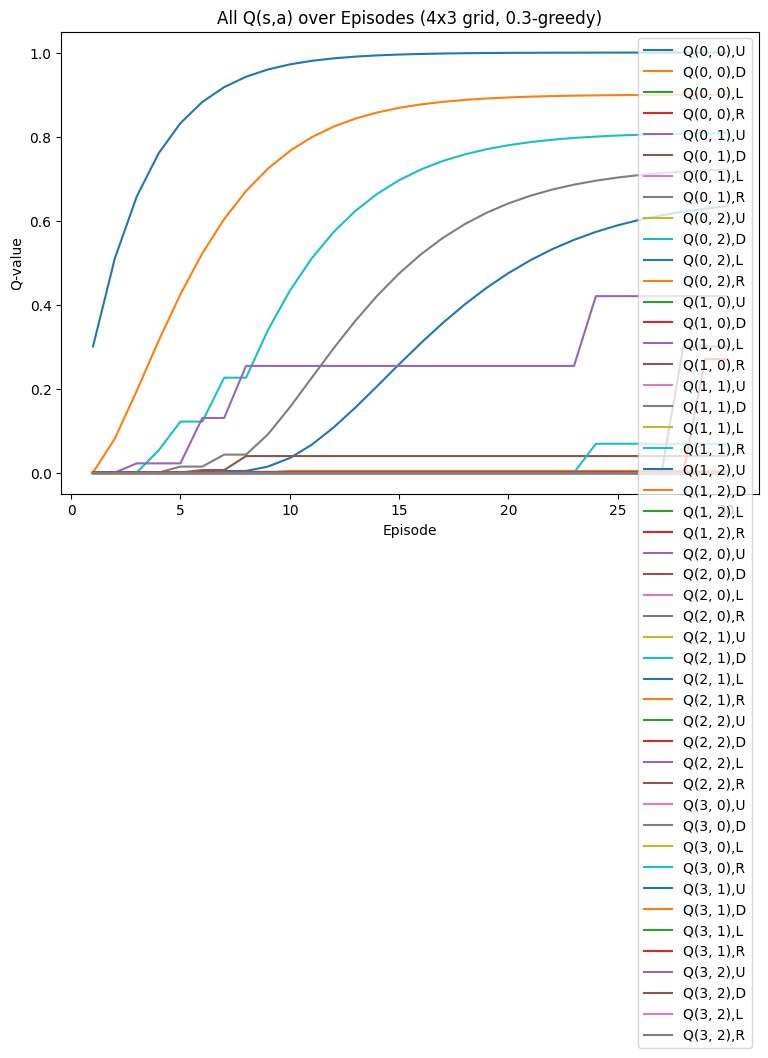

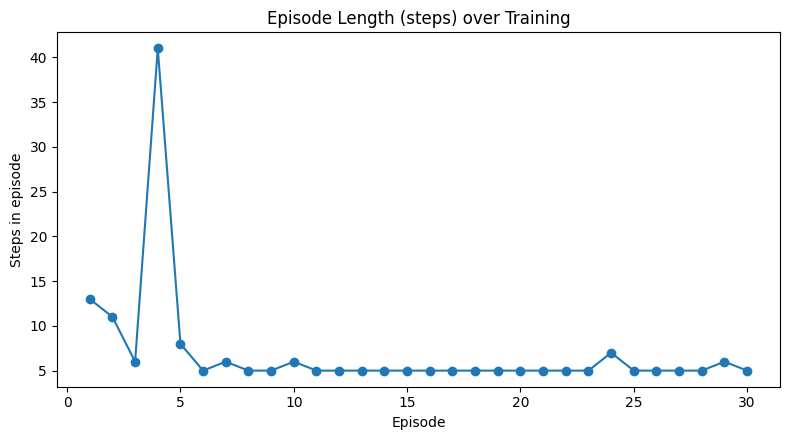

Final Q-values and Policy:
     state         U         D    L         R greedy_action
0   (0, 0)  0.634131  0.003835  0.0  0.001594             U
1   (0, 1)  0.000000  0.000000  0.0  0.721699             R
2   (0, 2)  0.000000  0.000000  0.0  0.000000             R
3   (1, 0)  0.000000  0.000000  0.0  0.039220             R
4   (1, 1)  0.000000  0.000000  0.0  0.808156             R
5   (1, 2)  0.000000  0.000000  0.0  0.000000             L
6   (2, 0)  0.420020  0.000000  0.0  0.000000             U
7   (2, 1)  0.000000  0.068558  0.0  0.899611             R
8   (2, 2)  0.000000  0.000000  0.0  0.300000             R
9   (3, 0)  0.000000  0.000000  0.0  0.000000             U
10  (3, 1)  0.999968  0.000000  0.0  0.269982             U
11  (3, 2)  0.000000  0.000000  0.0  0.000000          None
Greedy path from start to terminal: [(0, 0), (0, 1), (1, 1), (2, 1), (3, 1), (3, 2)]


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)  # for reproducibility

    GRID_SIZE = (4, 3)  # rows, cols
    gamma = 0.9
    epsilon = 0.3  # exploration rate
    beta = 0.01  # decay rate for epsilon
    episodes = 30
    start_state = (0, 0)
    terminal_state = (3, 2)
    max_steps_per_episode = 100

    agent = GridQLearning(
        grid_size=GRID_SIZE,
        start_state=start_state,
        terminal_state=terminal_state,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        beta=beta,
        episodes=episodes,
        max_steps_per_episode=max_steps_per_episode
    )

    print("Training Q-learning agent...")
    agent.train()
    agent.plot_results()

    df_final, path = agent.get_final_results()


Training Q-learning agent...
3x3 Gridworld Q(s,a) by Episode (ε-greedy)
         Q(0, 0),U  Q(0, 0),D  Q(0, 0),L  Q(0, 0),R  Q(0, 1),U  Q(0, 1),D  \
Episode                                                                     
1         0.000000   0.000000   0.000000        0.0   0.000000   0.000000   
2         0.000000   0.000000   0.000000        0.0   0.000000   0.000000   
3         0.000000   0.000000   0.000000        0.0   0.000000   0.000000   
4         0.000000   0.000000   0.000000        0.0   0.005905   0.000000   
5         0.001594   0.000000   0.000000        0.0   0.034012   0.000000   
6         0.010299   0.000000   0.000000        0.0   0.059474   0.000000   
7         0.023268   0.000000   0.000000        0.0   0.097551   0.000000   
8         0.042626   0.000000   0.000000        0.0   0.138383   0.000000   
9         0.067202   0.000000   0.000000        0.0   0.207191   0.000000   
10        0.102983   0.000000   0.000000        0.0   0.271607   0.000000   
11  

/var/folders/gd/yqjzn9wx32z1wh0n8phrb9d40000gn/T/ipykernel_29385/682661846.py:131: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


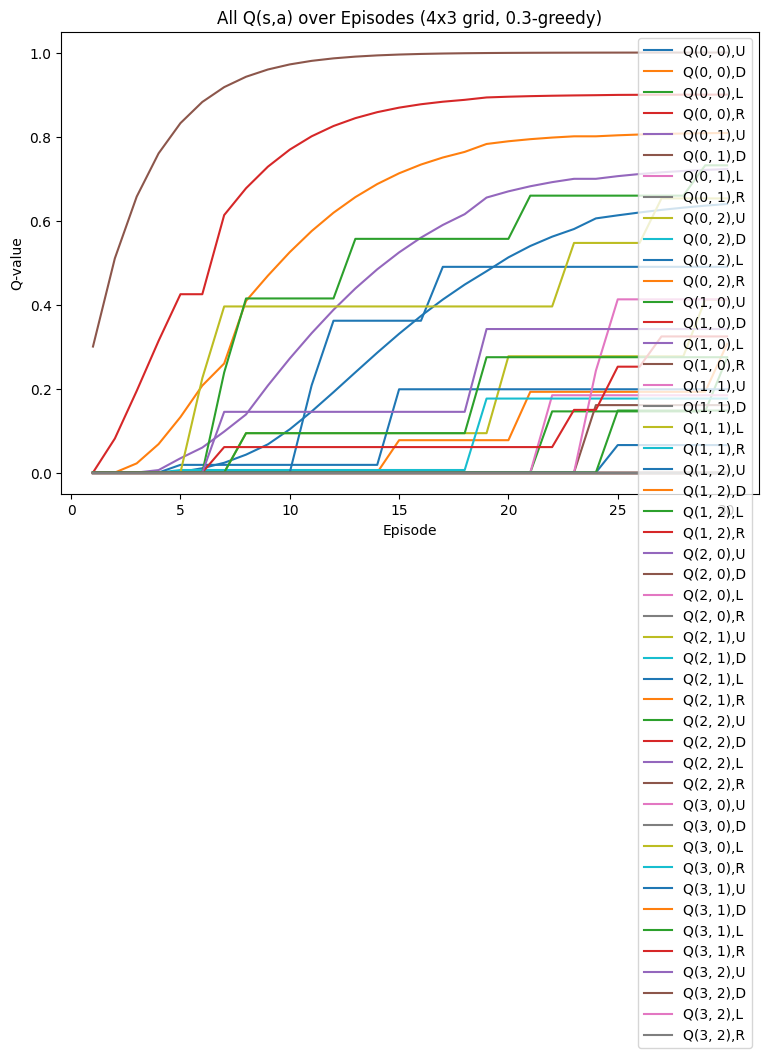

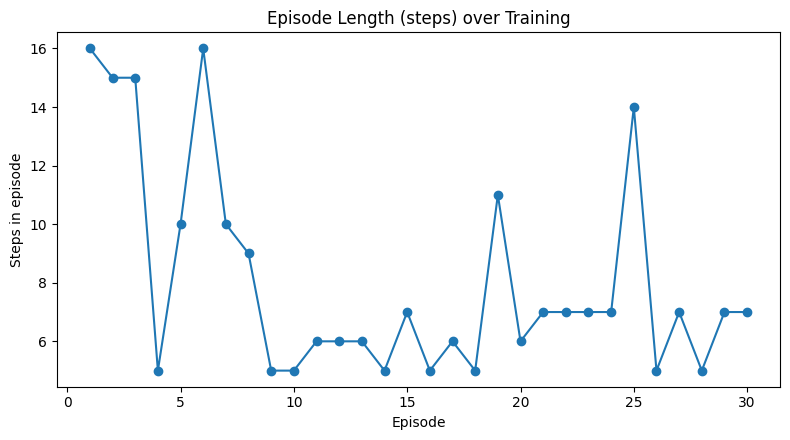

Final Q-values and Policy:
     state         U         D         L         R greedy_action
0   (0, 0)  0.639366  0.306150  0.273514  0.000000             U
1   (0, 1)  0.722583  0.160572  0.184041  0.000000             U
2   (0, 2)  0.411754  0.176165  0.198276  0.808513             R
3   (1, 0)  0.000000  0.000000  0.000000  0.000000             R
4   (1, 1)  0.412403  0.000000  0.000000  0.000000             U
5   (1, 2)  0.489796  0.000000  0.274617  0.899816             R
6   (2, 0)  0.000000  0.000000  0.000000  0.000000             U
7   (2, 1)  0.652681  0.000000  0.065458  0.000000             U
8   (2, 2)  0.731489  0.324069  0.341704  0.999977             R
9   (3, 0)  0.000000  0.000000  0.000000  0.000000             D
10  (3, 1)  0.000000  0.000000  0.147615  0.000000             L
11  (3, 2)  0.000000  0.000000  0.000000  0.000000          None
Greedy path from start to terminal: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2)]


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)  # for reproducibility
    GRID_SIZE = (4, 3)  # rows, cols
    gamma = 0.9
    epsilon = 0.3  # exploration rate
    beta = 0.001  # decay rate for epsilon, the larger the slower the decay, the longer it takes to converge
    episodes = 30
    start_state = (0, 0)
    terminal_state = (3, 2)
    max_steps_per_episode = 100

    agent = GridQLearning(
        grid_size=GRID_SIZE,
        start_state=start_state,
        terminal_state=terminal_state,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        beta=beta,
        episodes=episodes,
        max_steps_per_episode=max_steps_per_episode
    )

    print("Training Q-learning agent...")
    agent.train()
    agent.plot_results()

    df_final, path = agent.get_final_results()

In [63]:
np.random.seed(42)
np.random.rand(), np.random.rand(), np.random.rand()


(0.3745401188473625, 0.9507143064099162, 0.7319939418114051)